# Movie Recommendation System using Collaborative Filtering
This notebook implements a collaborative filtering recommendation system using K-Nearest Neighbors (KNN) algorithm. Thesystem recommends movies based on user rating patterns and movie similarities.

## Dataset Overview
- **TMDB 5000 Movies**: Contains movie metadata including titles and IDs
- **MovieLens Dataset**: Contains user ratings and movie links

## Approach
1. Data preprocessing and merging
2. Exploratory data analysis
3. Data filtering based on minimum ratings threshold
4. Creating user-item matrix
5. Building KNN model for similarity calculation
6. Implementing recommendation function

## 1. Import Required Libraries

Import necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
# Data manipulation and visualization libraries
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning libraries
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## 2. Data Loading

Load the three main datasets:
- **movies_df**: TMDB movie metadata (titles, genres, etc.)
- **links_df**: Mapping between different movie ID systems
- **ratings_df**: User ratings for movies

In [2]:
# Load movie metadata from TMDB dataset
movies_df = pd.read_csv("../data/raw/tmdb_5000_movie_dataset/tmdb_5000_movies.csv")

# Load movie ID mappings (movieId to tmdbId)
links_df = pd.read_csv("../data/raw/the_movie_dataset/links.csv")

# Load user ratings data
ratings_df = pd.read_csv("../data/raw/the_movie_dataset/ratings.csv")

print(f"Movies dataset shape: {movies_df.shape}")
print(f"Links dataset shape: {links_df.shape}")
print(f"Ratings dataset shape: {ratings_df.shape}")

Movies dataset shape: (4803, 20)
Links dataset shape: (45843, 3)
Ratings dataset shape: (26024289, 4)


## 3. Data Preprocessing
    
Rename the 'id' column in movies_df to 'tmdbId' for consistency withthe links dataset.

In [3]:
# Rename 'id' column to 'tmdbId' for consistent naming across datasets
movies_df = movies_df.rename(columns={'id': 'tmdbId'})

print("Column renaming completed. Movies dataset columns:")
print(movies_df.columns.tolist())

Column renaming completed. Movies dataset columns:
['budget', 'genres', 'homepage', 'tmdbId', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']


## 4. Data Merging and Cleaning
    
Merge the ratings and links datasets to connect user ratings with TMDB movie IDs, then remove records with missing TMDB IDs.

In [4]:
# Merge ratings with movie links to get tmdbId for each rating
final_merged_df = pd.merge(ratings_df, links_df, on='movieId', how='left')

# Remove records where tmdbId is missing (movies not in TMDB dataset)
final_cleaned_df = final_merged_df.dropna(subset=['tmdbId'])

print(f"Original merged dataset shape: {final_merged_df.shape}")
print(f"Cleaned dataset shape (after removing NaN tmdbId): {final_cleaned_df.shape}")
print(f"Records removed: {final_merged_df.shape[0] - final_cleaned_df.shape[0]}")

Original merged dataset shape: (26024289, 6)
Cleaned dataset shape (after removing NaN tmdbId): (26010786, 6)
Records removed: 13503


 ## 5. Exploratory Data Analysis
    
Analyze the distribution of ratings per movie and per user to understand data sparsity and determine appropriate filtering thresholds.

In [5]:
# Calculate number of users who rated each movie
no_user_voted = final_merged_df.groupby("tmdbId")['rating'].agg('count')

# Calculate number of movies rated by each user
no_movies_voted = final_merged_df.groupby("userId")['rating'].agg('count')

print(f"Average ratings per movie: {no_user_voted.mean():.2f}")
print(f"Average movies rated per user: {no_movies_voted.mean():.2f}")
print(f"Movies with >10 ratings: {(no_user_voted > 10).sum()}")
print(f"Users with >50 ratings: {(no_movies_voted > 50).sum()}")

Average ratings per movie: 579.67
Average movies rated per user: 96.07
Movies with >10 ratings: 20537
Users with >50 ratings: 102379


### 5.1 Visualization: Number of Users per Movie
    
This scatter plot shows the distribution of user ratings across movies. The green line indicates our threshold (10 ratings minimum).

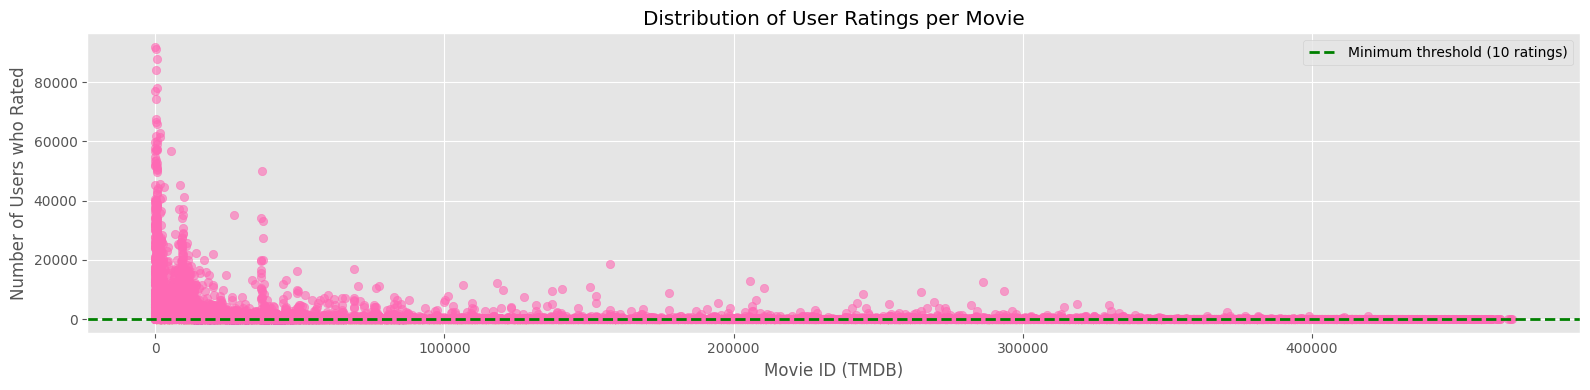

In [6]:
# Visualize distribution of ratings per movie
plt.style.use("ggplot")
fig, axes = plt.subplots(1, 1, figsize=(16, 4))

plt.scatter(no_user_voted.index, no_user_voted, color="hotpink", alpha=0.6)
plt.axhline(y=10, color='green', linestyle='--', linewidth=2, label='Minimum threshold (10 ratings)')
plt.xlabel("Movie ID (TMDB)")
plt.ylabel("Number of Users who Rated")
plt.title("Distribution of User Ratings per Movie")
plt.legend()
plt.tight_layout()
plt.show()

### 5.2 Visualization: Number of Movies per User
    
This scatter plot shows how many movies each user has rated. The green line indicates our threshold (50 ratings minimum).

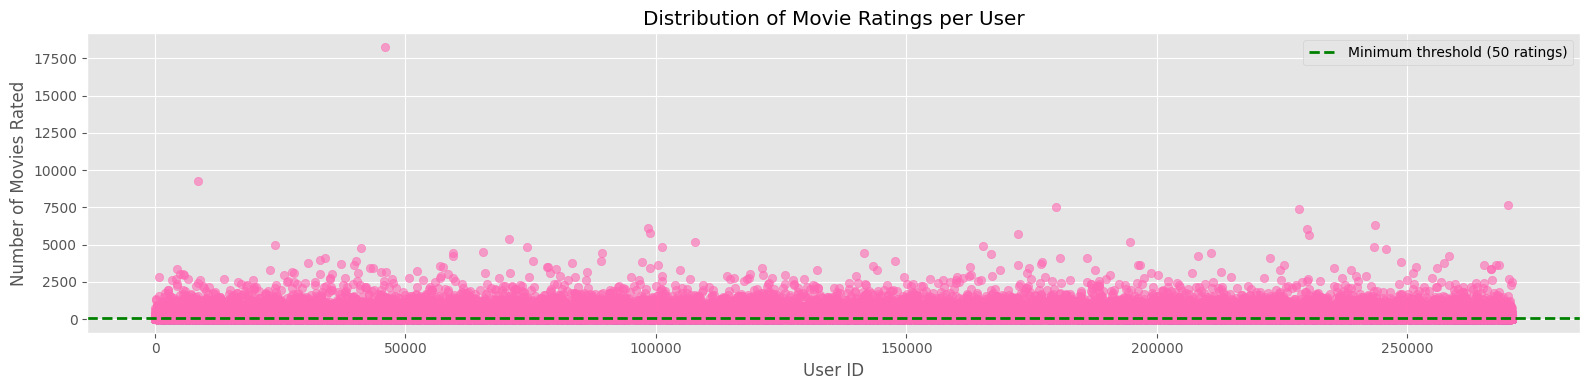

In [7]:
# Visualize distribution of movies rated per user
plt.style.use("ggplot")
fig, axes = plt.subplots(1, 1, figsize=(16, 4))

plt.scatter(no_movies_voted.index, no_movies_voted, color="hotpink", alpha=0.6)
plt.axhline(y=50, color='green', linestyle='--', linewidth=2, label='Minimum threshold (50 ratings)')
plt.xlabel("User ID")
plt.ylabel("Number of Movies Rated")
plt.title("Distribution of Movie Ratings per User")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Data Filtering
    
Apply filtering thresholds to reduce sparsity:
- Keep only users who have rated at least 50 movies
- Keep only movies that have been rated by at least 100 users
    
This filtering helps improve recommendation quality by focusing on users and movies with sufficient data.

In [8]:
# Filter users: keep only users who have rated at least 50 movies
min_user_ratings = 50
filtered_users = final_cleaned_df['userId'].value_counts()
filtered_users = filtered_users[filtered_users >= min_user_ratings].index
final_dataset = final_cleaned_df[final_cleaned_df['userId'].isin(filtered_users)]

print(f"Users after filtering (min {min_user_ratings} ratings): {len(filtered_users)}")
print(f"Dataset shape after user filtering: {final_dataset.shape}")

# Filter movies: keep only movies with at least 100 ratings
min_movie_ratings = 100
filtered_movies = final_dataset['tmdbId'].value_counts()
filtered_movies = filtered_movies[filtered_movies >= min_movie_ratings].index
final_dataset = final_dataset[final_dataset['tmdbId'].isin(filtered_movies)]

print(f"Movies after filtering (min {min_movie_ratings} ratings): {len(filtered_movies)}")
print(f"Final dataset shape after movie filtering: {final_dataset.shape}")

Users after filtering (min 50 ratings): 103787
Dataset shape after user filtering: (22865938, 6)
Movies after filtering (min 100 ratings): 9828
Final dataset shape after movie filtering: (22421221, 6)


## 7. Create User-Item Matrix
    
Transform the data into a user-item matrix where:
- Rows represent movies (tmdbId)
- Columns represent users (userId)
- Values represent ratings
    
This matrix structure is required for collaborative filtering algorithms.

In [9]:
# Create pivot table: movies as rows, users as columns, ratings as values
final_dataset = final_dataset.pivot_table(index="tmdbId", columns="userId", values="rating")

print(f"User-item matrix shape: {final_dataset.shape}")
print(f"Matrix dimensions: {final_dataset.shape[0]} movies × {final_dataset.shape[1]} users")

User-item matrix shape: (9828, 103787)
Matrix dimensions: 9828 movies × 103787 users


## 8. Handle Missing Values

Fill missing values (NaN) with 0. This represents movies that users haven't rated.
    
**Note**: Alternative approaches could include using the user's mean rating or more sophisticated imputation methods.

In [10]:
# Fill NaN values with 0 (indicating no rating)
# Alternative: could use user mean rating or matrix factorization for imputation
final_dataset.fillna(0, inplace=True)

# Calculate sparsity of the matrix
total_cells = final_dataset.shape[0] * final_dataset.shape[1]
non_zero_cells = (final_dataset != 0).sum().sum()
sparsity = (1 - non_zero_cells / total_cells) * 100

print(f"Matrix sparsity: {sparsity:.2f}%")
print(f"Non-zero ratings: {non_zero_cells:,} out of {total_cells:,} possible ratings")

Matrix sparsity: 97.80%
Non-zero ratings: 22,421,109 out of 1,020,018,636 possible ratings


## 9. Save Processed Data
    
Save the user-item matrix for future use or analysis.

In [11]:
# Save the processed user-item matrix to CSV
# Note: This will save without the tmdbId index, so we'll reset index before saving
# final_dataset_to_save = final_dataset.reset_index()
# final_dataset_to_save.to_csv("../data/processed/user_item_matrix.csv", index=False)

# print("User-item matrix saved to: ../data/processed/user_item_matrix.csv")

## 10. Data Preview
    
Preview the final user-item matrix structure and dimensions.

In [12]:
# Display first few rows of the user-item matrix
print("User-Item Matrix Preview:")
print("="*50)
final_dataset.head()

User-Item Matrix Preview:


userId,4,7,8,9,11,12,15,16,20,24,...,270871,270872,270877,270879,270885,270887,270892,270893,270894,270896
tmdbId,,,,,,,,,,,,,,,,,,,,,
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11.0,0.0,0.0,0.0,0.0,3.0,5.0,1.5,3.5,4.0,5.0,...,5.0,4.5,0.0,5.0,0.0,5.0,5.0,0.0,2.5,0.0
12.0,0.0,3.5,0.0,0.0,3.5,0.0,4.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0


In [13]:
# Display final matrix dimensions
print(f"Final user-item matrix shape: {final_dataset.shape}")
print(f"Total movies in recommendation system: {final_dataset.shape[0]}")
print(f"Total users in recommendation system: {final_dataset.shape[1]}")

Final user-item matrix shape: (9828, 103787)
Total movies in recommendation system: 9828
Total users in recommendation system: 103787


## 11. Prepare Data for Machine Learning
    
Convert the dense matrix to a sparse matrix format for memory efficiency and prepare data for the KNN algorithm.

In [14]:
# Convert to sparse matrix for memory efficiency
# CSR (Compressed Sparse Row) format is efficient for row-based operations
csr_data = csr_matrix(final_dataset.values)

# Reset index to make tmdbId accessible as a column
final_dataset.reset_index(inplace=True)

print(f"Sparse matrix shape: {csr_data.shape}")
print(f"Memory usage reduction: {(1 - csr_data.nnz / (csr_data.shape[0] * csr_data.shape[1])) * 100:.2f}%")

Sparse matrix shape: (9828, 103787)
Memory usage reduction: 97.80%


## 12. Train KNN Model
    
Initialize and train the K-Nearest Neighbors model using cosine similarity:
- **Metric**: Cosine similarity (good for high-dimensional sparse data)
- **Algorithm**: Brute force (guarantees exact results)
- **Neighbors**: 20 (finding top 20 similar movies)
- **n_jobs**: -1 (use all available CPU cores)

In [15]:
# Initialize KNN model with cosine similarity
# Cosine similarity works well for sparse rating data
knn = NearestNeighbors(
    metric='cosine',      # Use cosine similarity for high-dimensional sparse data
    algorithm='brute',    # Brute force algorithm for exact results
    n_neighbors=20,       # Find 20 most similar movies
    n_jobs=-1             # Use all available CPU cores
)

# Fit the model on the sparse matrix
knn.fit(csr_data)

print("KNN model trained successfully!")
print(f"Model configured to find {knn.n_neighbors} nearest neighbors using {knn.metric} similarity")

KNN model trained successfully!
Model configured to find 20 nearest neighbors using cosine similarity


 ## 13. Recommendation Function
    
Implement the main recommendation function that:
1. Searches for the input movie by name
2. Finds similar movies using the trained KNN model
3. Returns a ranked list of recommended movies with similarity scores

In [16]:
def get_recommendation(movie_name):
    """
    Get movie recommendations based on collaborative filtering using KNN.
    
    Args:
        movie_name (str): Name or partial name of the movie
        
    Returns:
        pandas.DataFrame: DataFrame containing recommended movies and their similarity distances
        str: Error message if movie not found
    """
    
    # Step 1: Search for movie by name (case-insensitive partial matching)
    movie_list = movies_df[movies_df['title'].str.contains(movie_name, case=False, na=False)]
    
    if len(movie_list) == 0:
        return f"Movie containing '{movie_name}' not found in database..."
    
    # Step 2: Get TMDB ID of the first matching movie
    movie_tmdb_id = movie_list.iloc[0]['tmdbId']
    movie_title = movie_list.iloc[0]['title']
    
    print(f"Found movie: '{movie_title}' (TMDB ID: {movie_tmdb_id})")
    
    # Step 3: Check if movie exists in our recommendation dataset
    final_movie_match = final_dataset[final_dataset['tmdbId'] == movie_tmdb_id]
    if len(final_movie_match) == 0:
        return f"Movie '{movie_title}' found but not available in recommendation dataset (insufficient ratings)..."
    
    # Step 4: Get the index of the movie in our matrix
    movie_idx_final = final_movie_match.index[0]
    
    # Step 5: Find similar movies using KNN
    # n_neighbors=11 to get 10 recommendations (excluding the input movie itself)
    distances, indices = knn.kneighbors(csr_data[movie_idx_final], n_neighbors=11)
    
    # Step 6: Sort recommendations by similarity (lower distance = more similar)
    # Skip the first result as it's the input movie itself
    rec_movies_indices = sorted(
        list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), 
        key=lambda x: x[1]  # Sort by distance (similarity)
    )[1:]  # Exclude the input movie (first result)
    
    # Step 7: Build recommendations list
    recommended_movies = []
    
    for idx, distance in rec_movies_indices:
        try:
            # Get TMDB ID from our dataset
            rec_movie_tmdb_id = final_dataset.iloc[idx]['tmdbId']
            
            # Find movie details in the movies dataset
            movie_match = movies_df[movies_df['tmdbId'] == rec_movie_tmdb_id]
            
            if len(movie_match) > 0:
                # Calculate similarity score (1 - distance)
                similarity_score = 1 - distance
                
                recommended_movies.append({
                    'Title': movie_match.iloc[0]['title'], 
                    'Similarity_Score': round(similarity_score, 4),
                    'Distance': round(distance, 4)
                })
            else:
                print(f"Warning: Movie with TMDB ID {rec_movie_tmdb_id} not found in movies database")
                continue
                
        except Exception as e:
            print(f"Error processing recommendation at index {idx}: {e}")
            continue
    
    # Step 8: Return results
    if len(recommended_movies) == 0:
        return "No recommendations found..."
    
    # Create DataFrame with proper indexing
    recommendations_df = pd.DataFrame(
        recommended_movies, 
        index=range(1, len(recommended_movies) + 1)
    )
    
    print(f"\nTop 10 recommendations for '{movie_title}':")
    print("="*60)
    
    return recommendations_df

## 14. Test the Recommendation System
    
Test the recommendation function with a popular movie to see how well it performs.

In [17]:
# Test the recommendation system with "Interstellar"
recommendations = get_recommendation("Interstella")
print(recommendations)

Found movie: 'Interstellar' (TMDB ID: 157336)

Top 10 recommendations for 'Interstellar':
                      Title  Similarity_Score  Distance
1               The Martian            0.6444    0.3556
2                 Inception            0.6398    0.3602
3          Django Unchained            0.6177    0.3823
4        The Imitation Game            0.6167    0.3833
5          Edge of Tomorrow            0.6154    0.3846
6                Ex Machina            0.6073    0.3927
7     The Dark Knight Rises            0.6060    0.3940
8        Mad Max: Fury Road            0.6020    0.3980
9                   Gravity            0.5926    0.4074
10  Guardians of the Galaxy            0.5905    0.4095
